<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_mbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using mean blood pressure values

In this example, we will learn how to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the mean blood pressure (MBP) value read from the patient monitor (GE Solar 8000M) on VitalDB dataset.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [2]:
!pip install vitaldb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import vitaldb
import warnings
warnings.filterwarnings('ignore')

## Case Selection

In [4]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[df_cases['caseend'] > 3600]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3420 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The MBP data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

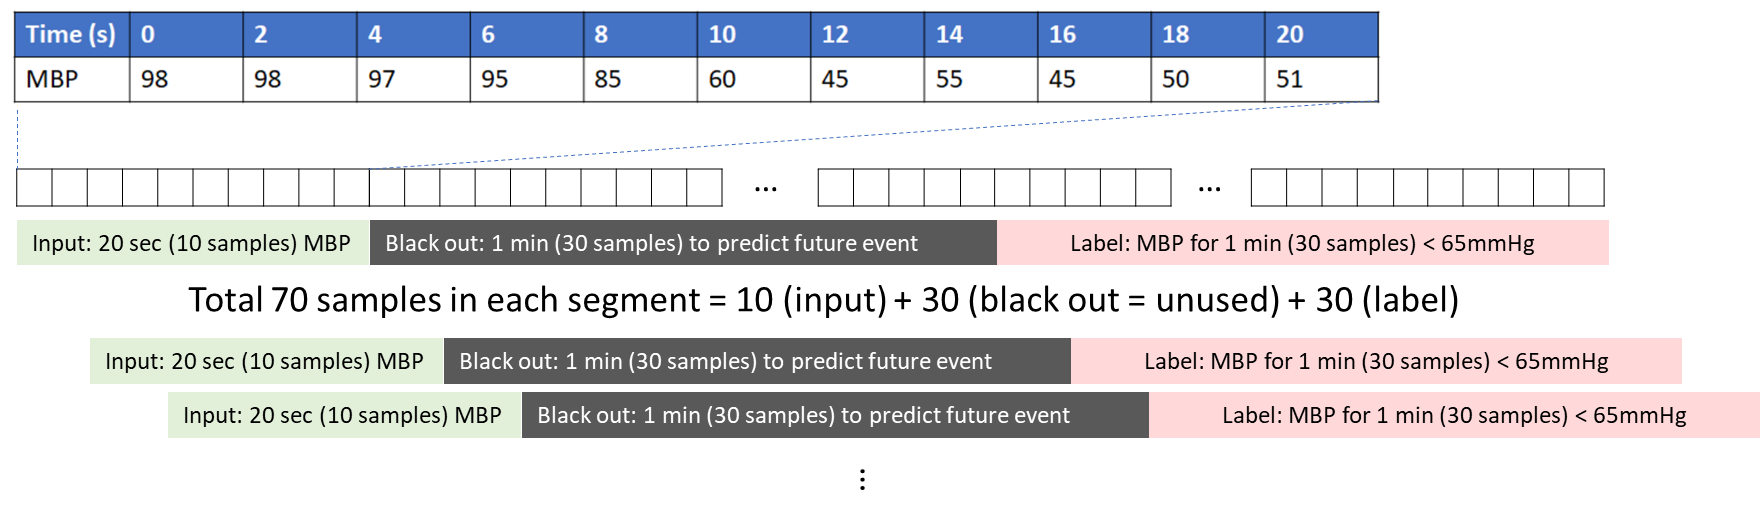

In [5]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure with 2 min interval
    mbps = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2).flatten()

    # samples before arterial catheter inserted
    mbps[mbps < 40] = np.nan

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        if np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 150).any():
            valid = False
        elif (segy > 150).any():
            valid = False
        elif (np.abs(np.diff(segx)) > 50).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 50).any():  # abrupt change -> noise
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 2815...5462 samples 50 (0.9 %) events
loading 34...10093 samples 0 (0.0 %) events
loading 6184...6552 samples 1 (0.0 %) events
loading 5237...2765 samples 0 (0.0 %) events
loading 441...5057 samples 2473 (48.9 %) events
loading 5203...7647 samples 51 (0.7 %) events
loading 1404...4350 samples 0 (0.0 %) events
loading 368...2596 samples 165 (6.4 %) events
loading 1558...5934 samples 1273 (21.5 %) events
loading 1271...no samples
loading 4547...5267 samples 0 (0.0 %) events
loading 2508...7445 samples 0 (0.0 %) events
loading 990...5189 samples 0 (0.0 %) events
loading 3057...1884 samples 0 (0.0 %) events
loading 6166...10812 samples 669 (6.2 %) events
loading 1012...4807 samples 40 (0.8 %) events
loading 3799...1404 samples 14 (1.0 %) events
loading 5116...2267 samples 89 (3.9 %) events
loading 3463...8750 samples 18 (0.2 %) events
loading 6208...3868 samples 47 (1.2 %) events
loading 3434...4668 samples 44 (0.9 %) events
loading 6368...7968 samples 3 (0.0 %) events
loading 5691

## Splitting samples into training and testing dataset


In [6]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 5ahead batchsize=256 total 664683, train 478816 (18014 events 3.8%), test 136030 (10453 events 7.7%)'

## Model building and training

In [7]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1680/1684 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.9285 - auc: 0.8331
Epoch 1: val_loss improved from inf to 0.10204, saving model to output/weights.hdf5
1684/1684 [==============================] - 19s 7ms/step - loss: 0.4032 - accuracy: 0.9285 - auc: 0.8331 - val_loss: 0.1020 - val_accuracy: 0.9812 - val_auc: 0.7980
Epoch 2/100
1676/1684 [============================>.] - ETA: 0s - loss: 0.3782 - accuracy: 0.9386 - auc: 0.8496
Epoch 2: val_loss did not improve from 0.10204
1684/1684 [==============================] - 10s 6ms/step - loss: 0.3781 - accuracy: 0.9387 - auc: 0.8497 - val_loss: 0.1216 - val_accuracy: 0.9724 - val_auc: 0.7946
Epoch 3/100
1681/1684 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.9379 - auc: 0.8499
Epoch 3: val_loss did not improve from 0.10204
1684/1684 [==============================] - 11s 6ms/step - loss: 0.3767 - accuracy: 0.9379 - auc: 0.8499 - val_loss: 0.1206 - val_accuracy: 0.9789 - v

2126

## Evaluation of the model performance

In [8]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(tempdir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(tempdir))
plt.close()

4251/4251 [==============================] - 9s 2ms/step
auroc=0.861, auprc=0.461 acc=0.932, F1=0.504, PPV=57.6, NPV=95.5, TN=122128, fp=3449, fn=5766, TP=4687


## Plotting each case in the test dataset

292/292 [==============================] - 1s 2ms/step
5403	0.23199378587769826	


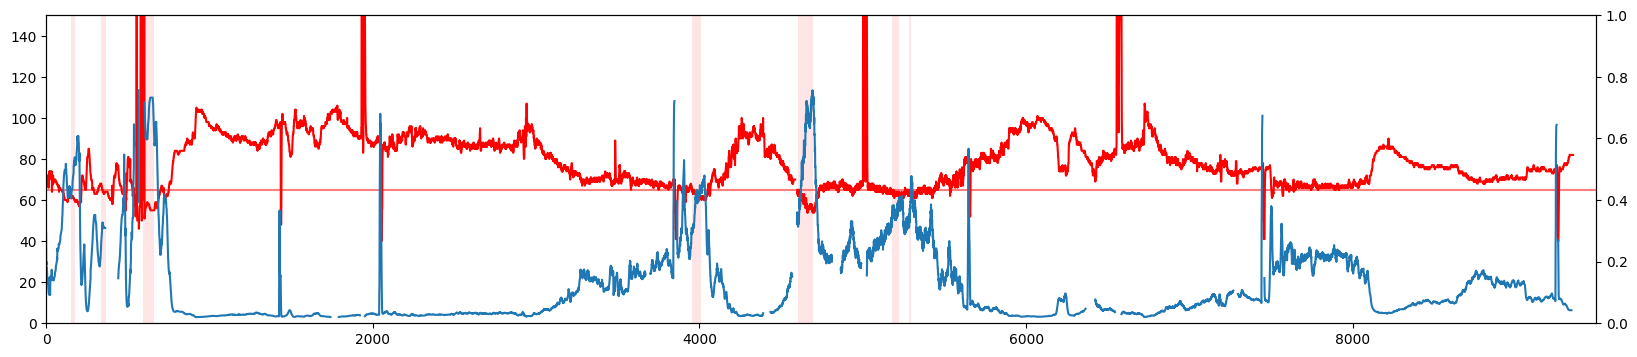

158/158 [==============================] - 0s 2ms/step
5486	0.2084283294261729	


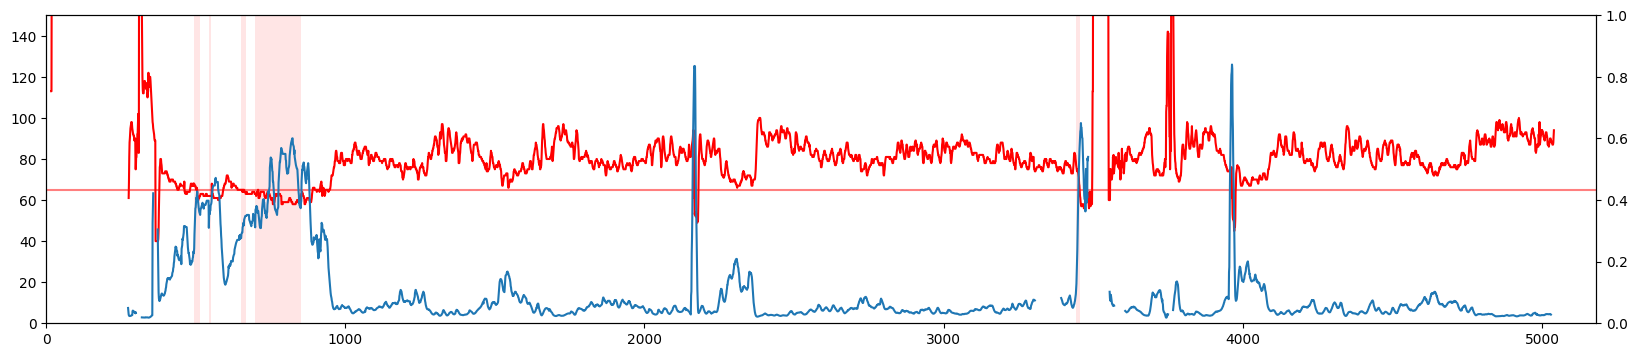

380/380 [==============================] - 1s 2ms/step
5595	0.3117171256422203	


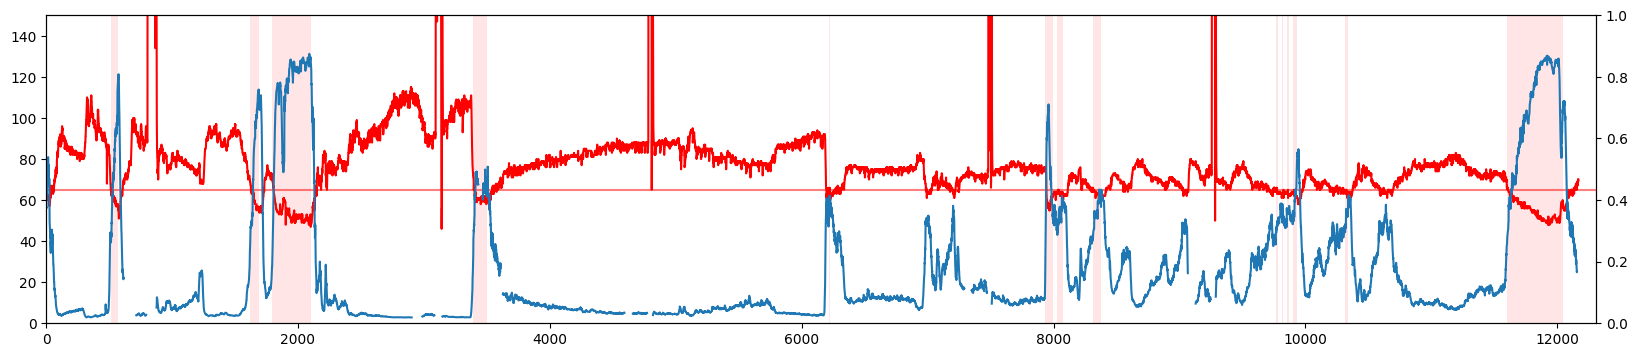

255/255 [==============================] - 1s 3ms/step
5676	0.1259484000848879	


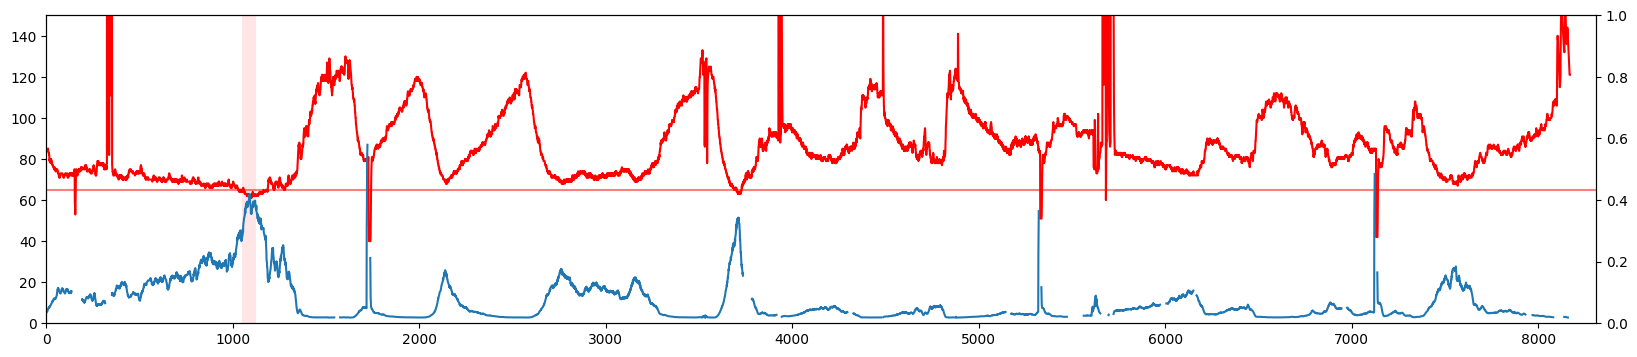

83/83 [==============================] - 0s 3ms/step
5691	0.22728311280612618	


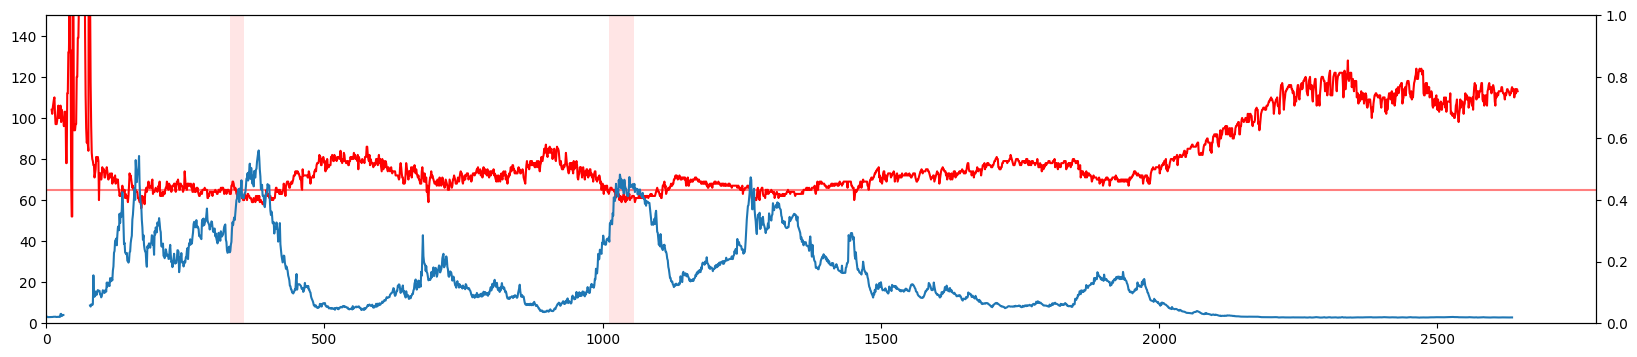

51/51 [==============================] - 0s 2ms/step
5800	0.04378896690489231	


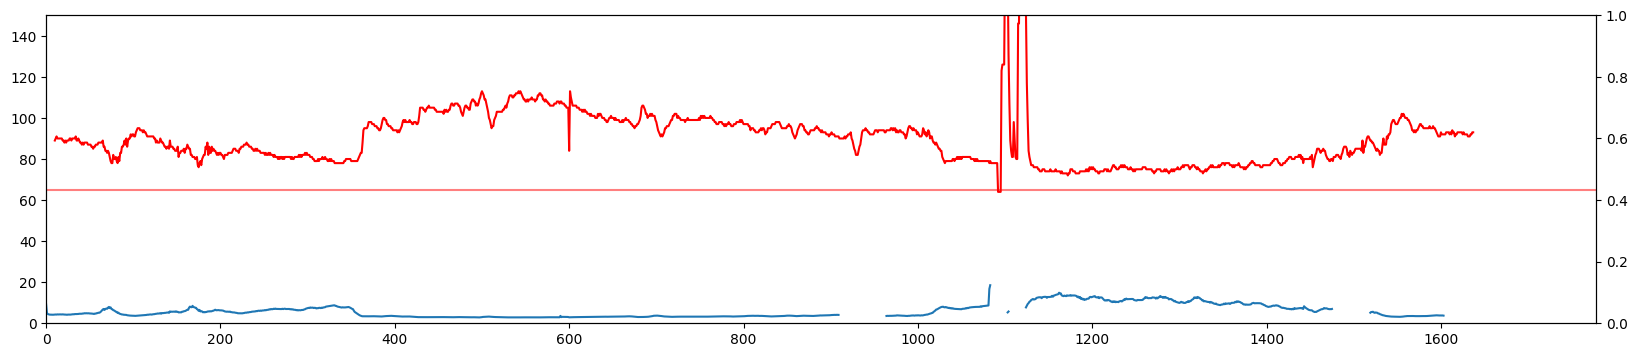

177/177 [==============================] - 0s 2ms/step
5829	0.23215259853166187	


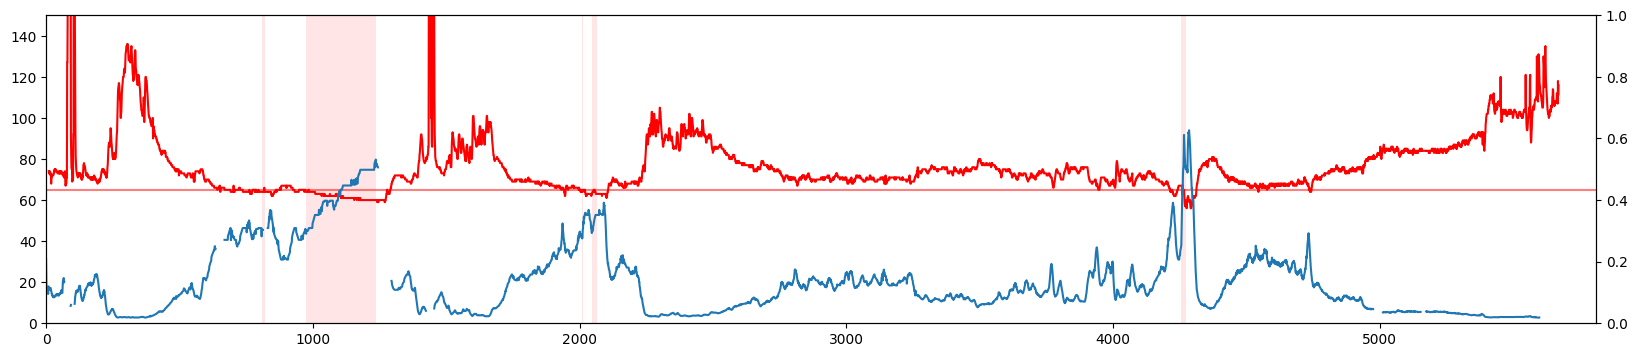

321/321 [==============================] - 1s 2ms/step
5937	0.13976842220699356	


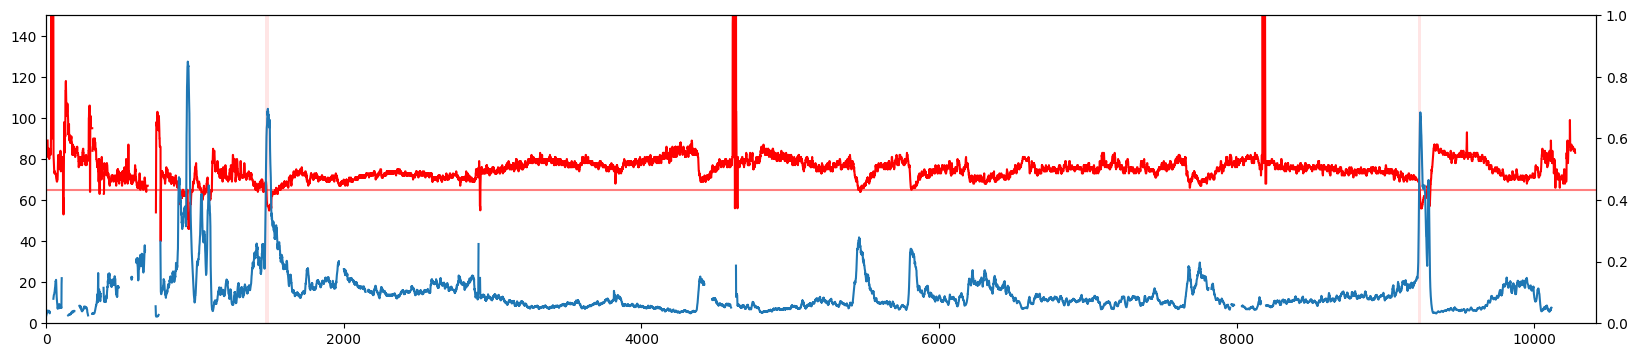

147/147 [==============================] - 0s 2ms/step
6018	0.1251059693932644	


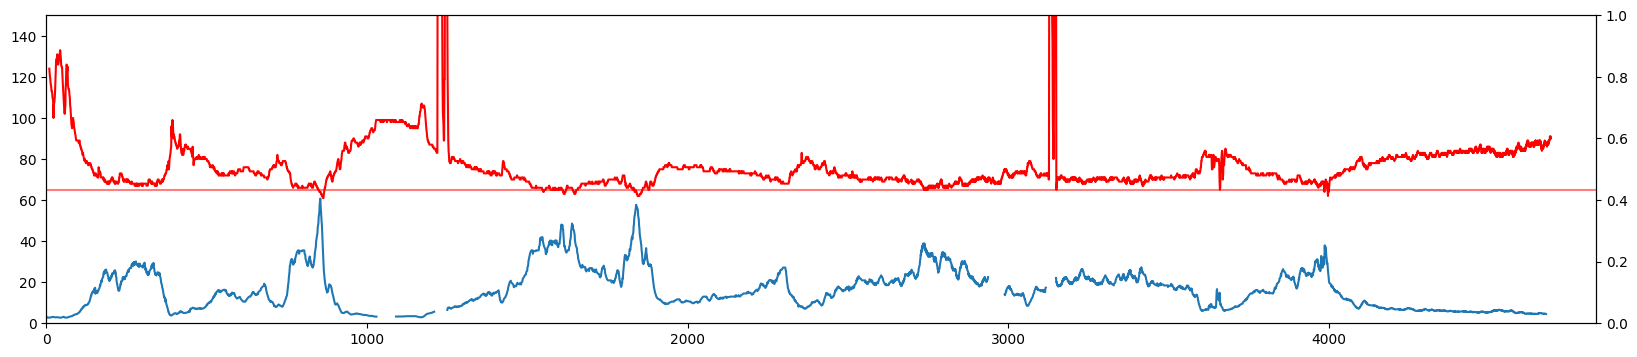

165/165 [==============================] - 0s 2ms/step
6032	0.039589180378562044	


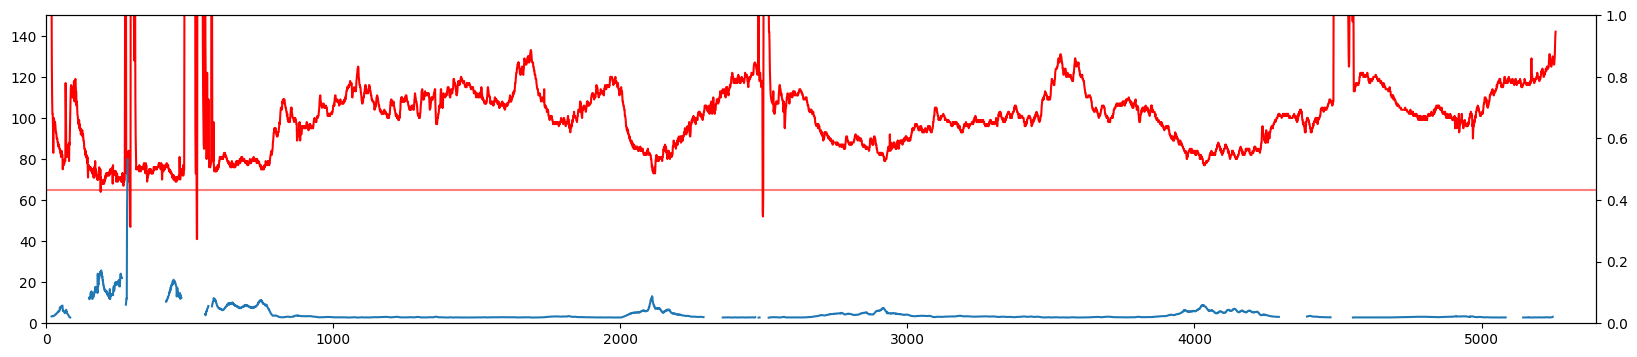

396/396 [==============================] - 1s 2ms/step
6166	0.27453306611122047	


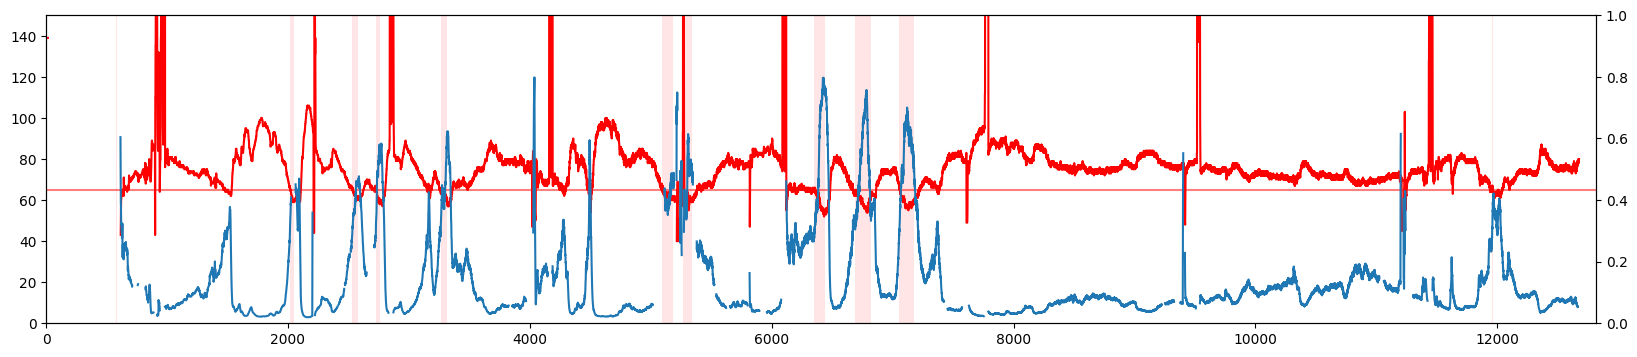

291/291 [==============================] - 1s 2ms/step
6182	0.16353438732222034	


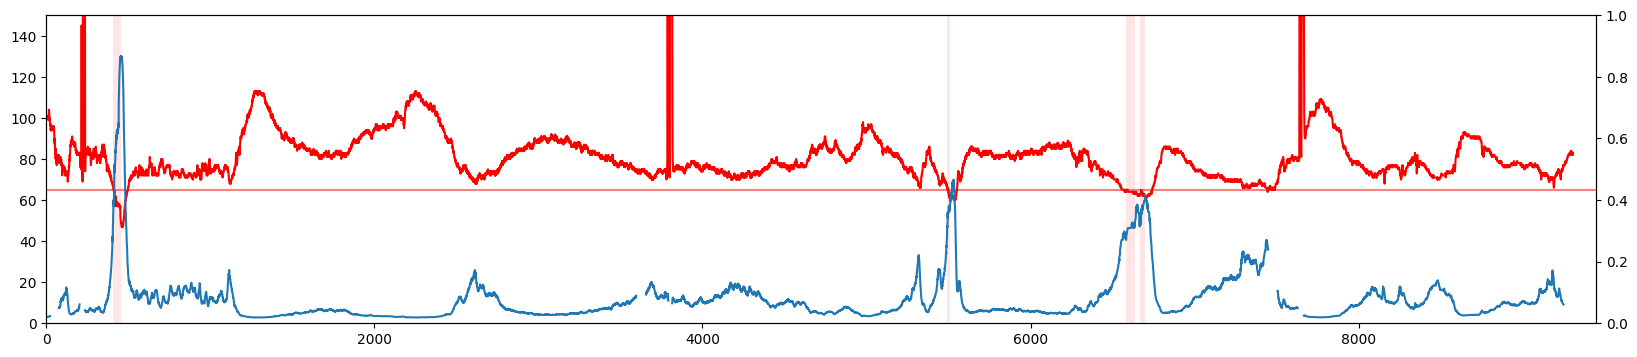

218/218 [==============================] - 1s 2ms/step
6184	0.09635220560019919	


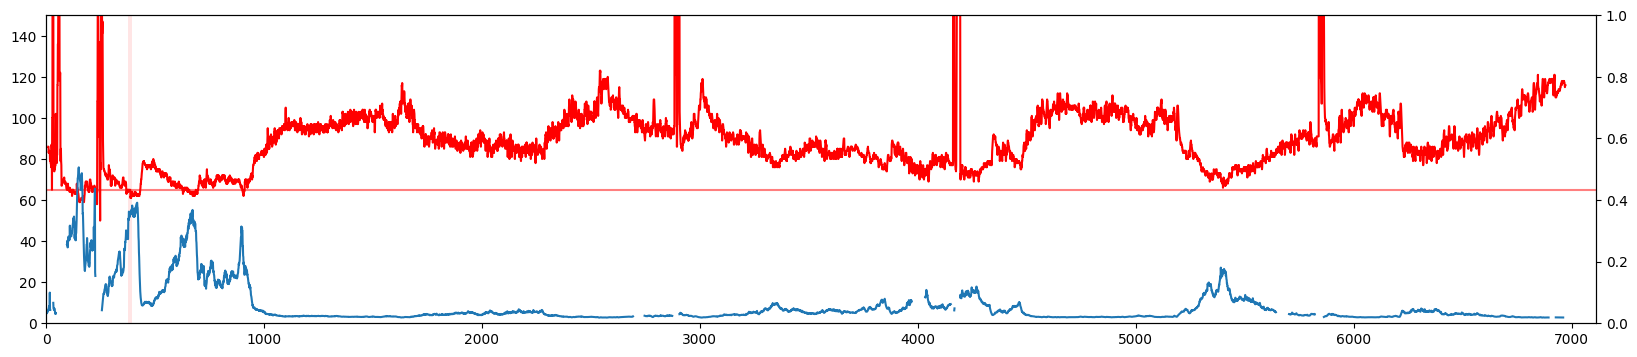

64/64 [==============================] - 0s 3ms/step
6206	0.258609954464565	


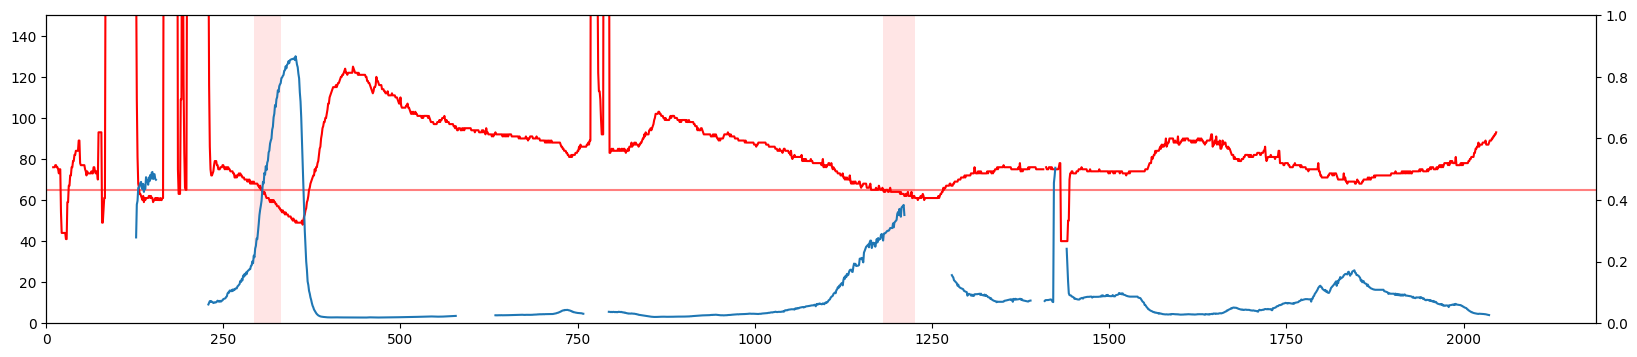

135/135 [==============================] - 0s 3ms/step
6208	0.16253376183625293	


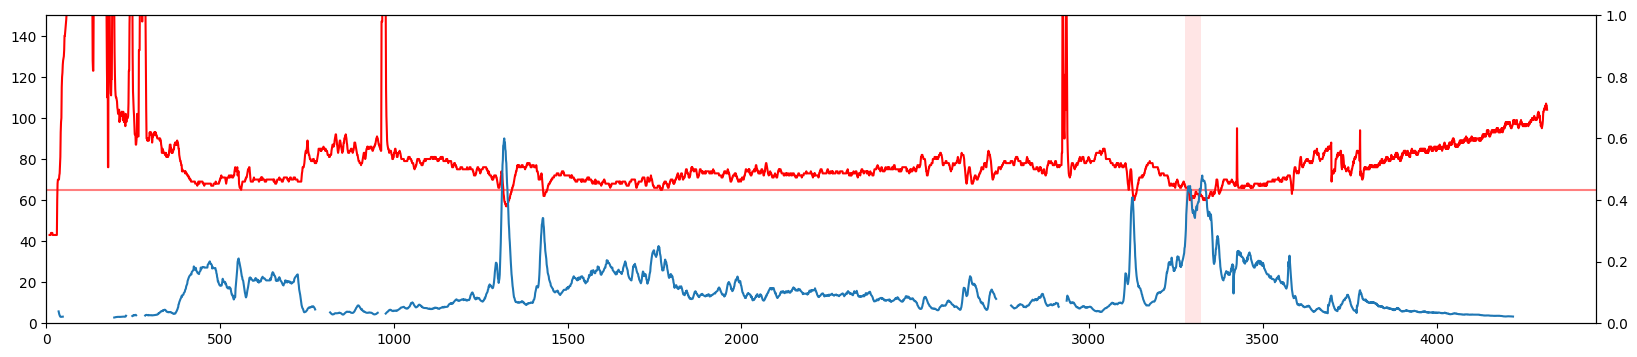

300/300 [==============================] - 1s 3ms/step
6217	0.2643481447680017	


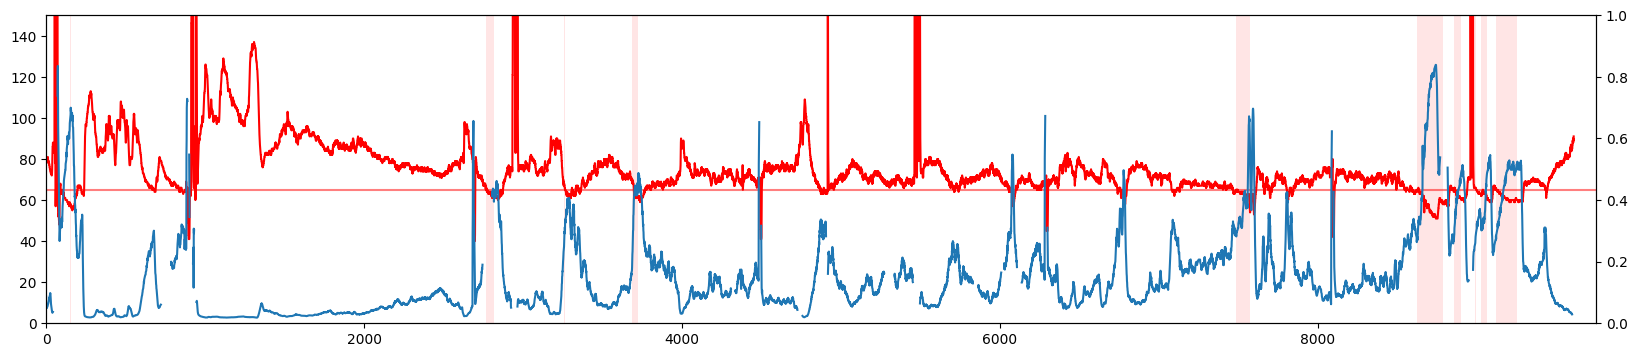

291/291 [==============================] - 1s 2ms/step
6281	0.2842892045770742	


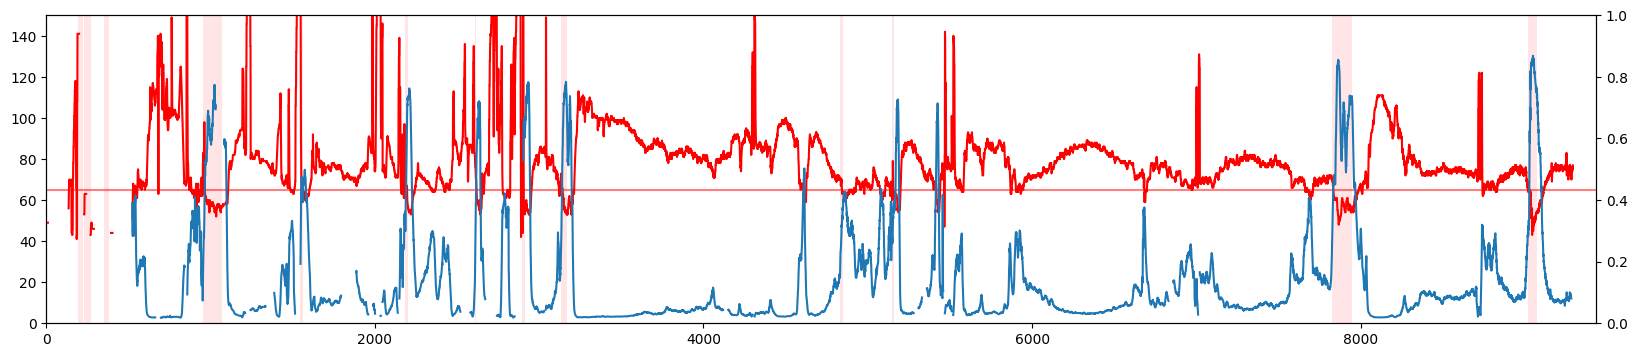

320/320 [==============================] - 1s 3ms/step
6290	0.44848121137612607	


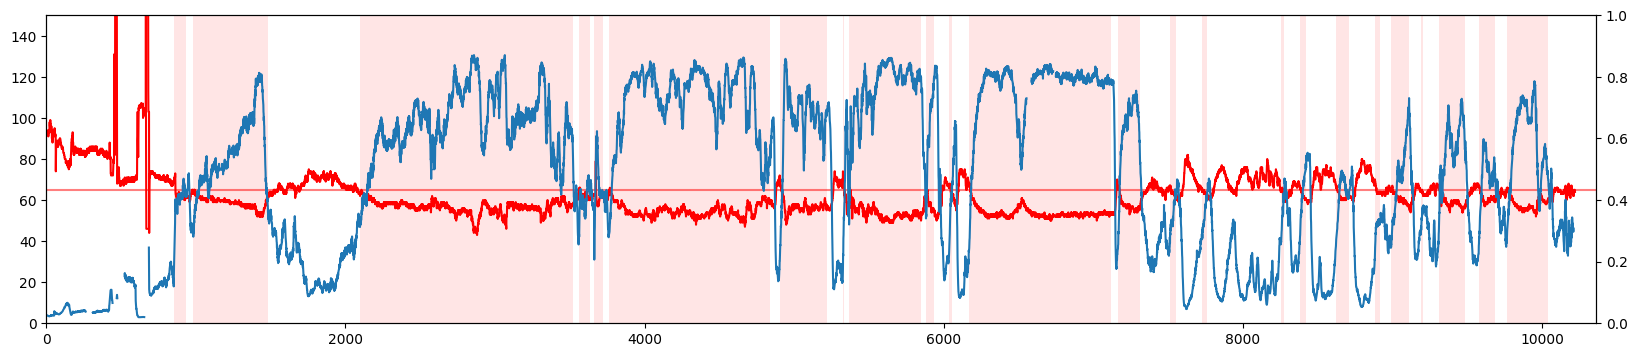

293/293 [==============================] - 1s 3ms/step
6360	0.19403952608476666	


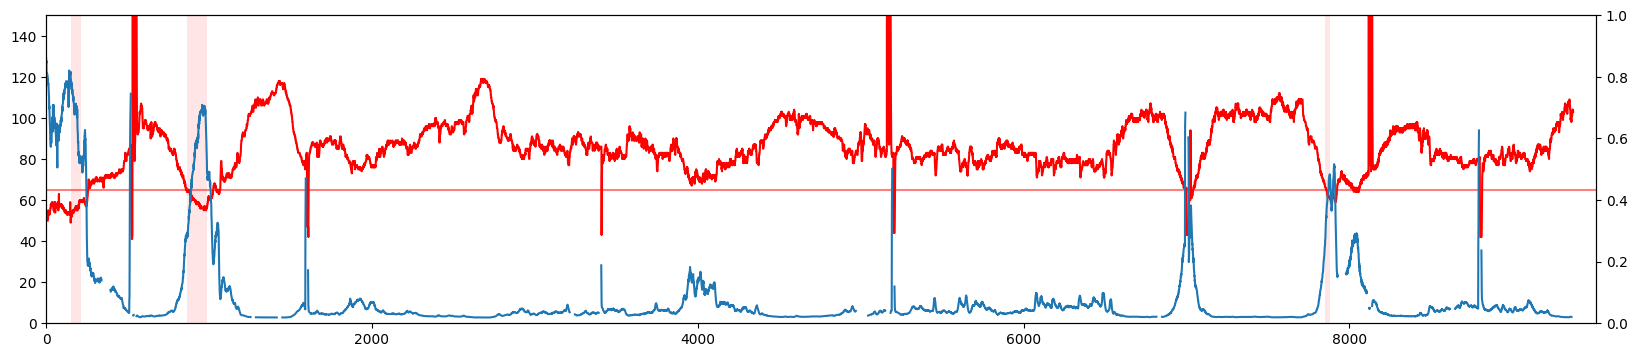

266/266 [==============================] - 1s 3ms/step
6368	0.08799483955404953	


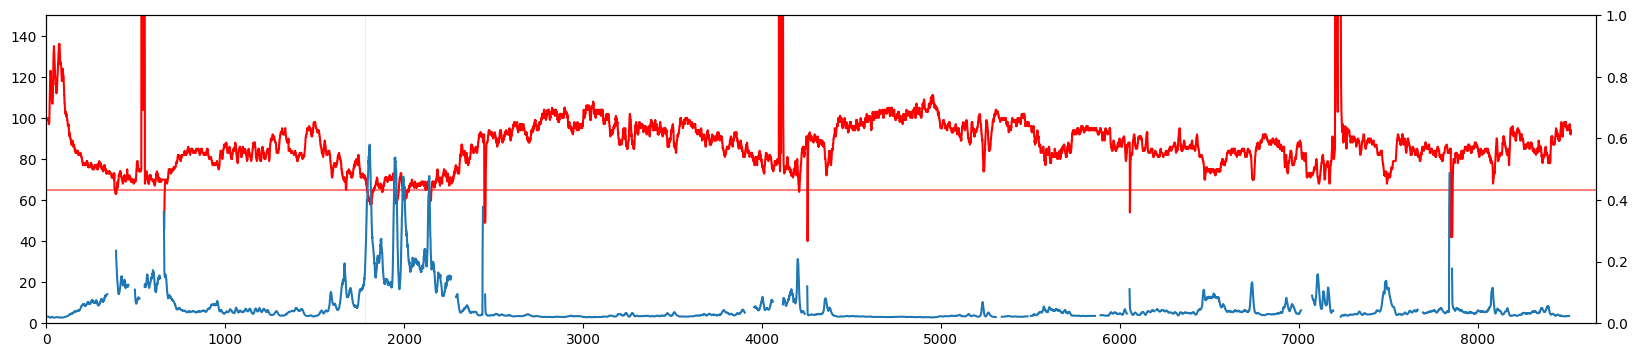

In [9]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()